# Reporte semanal 1

## Día 1: lunes 12 de junio del 2017

El día de hoy se me dio acceso a la computadora de escritorio que estaré usando para el proyecto. Dicha computadora fue formateada y preparada para contar con las herramientas necesarias para trabajar.

Una vez terminada la instalación de la computadora pasé al análisis del código para el problema JSSP. Tras su análisis se encontraron varios componentes que se cree pueden aportar información del comportamiento de las heurísticas. Dichos componentes se muestran dentro de la clase donde se hallan y el color azul simboliza que puede proporcionar información relevante:

* Programa principal
    * Número de máquinas
    * Número de trabajos
    * Número de operaciones por trabajo (mismo número para todas)
    * <span style="color:blue">Máxima temperatura del algoritmo</span>
    * <span style="color:blue">Mínima temperatura del algoritmo</span>
    * <span style="color:blue">Razón de cambio de la temperatura</span>
    * <span style="color:blue">Número de iteraciones que se deben realizar sin tener un cambio de temperatura</span>
    
    
* Por cada iteración que el algoritmo realice
    * Número actual de iteración
    * Mejor <i>Makespan</i> encontrado hasta el momento
    * Peor <i>Makespan</i> encontrado hasta el momento
    * <i>Makespan</i> actual
    
    
* Por cada operación
    * Duración
    * Tiempo de inicio
    * Tiempo de finalización
    * Máquina actual
    * Trabajo al que pertenece
    * Si ya fue aignado a una máquina
    
    
* Por cada máquina
    * Las operaciones que va a ejecutar
    * Tiempo desperdiciado por esperar antes de la última operación
    
    
* Por cada trabajo
    * Tiempo de inicio
    * Tiempo de finalización
    
    
* Solución
    * <span style="color:blue">Temperatura actual</span>
    * <span style="color:blue">Operaciones que fueron intercambiadas</span>
    * <span style="color:blue">Operaciones más grandes antes que más pequeñas</span>
    * <span style="color:blue">Operaciones más pequeñas antes que más grandes</span>
    * <span style="color:blue">Operaciones adyacentes</span>
    * <span style="color:blue">Veces que la función `should_accept` regresa verdadero</span>
    * <span style="color:blue">Veces que la función `should_accept` regresa un valor numérico diferente de cero</span>
    * <span style="color:blue">Veces que la función `should_accept` regresa un valor numérico igual a cero</span>
    * <span style="color:blue">Características de las operaciones que fueron asignads como iniciales</span>
        * Duración
        * Número de veces que se movieron
          
    * <span style="color:blue">Veces que se violó un *constraint*</span>
    * <span style="color:blue">Máquina que fue escogida aleatoriamente en `create_neighbor`</span>
    
De la misma forma se preparó un mecanismo para indicar al programa cuándo se requieren trazas, información para *debugging* y recolección de datos. Éste mecanismo funciona mediante banderas cuando se ejecuta el programa. El código que implementa esta funcionalidad se muestra a continuación: 

In [ ]:
from optparse import OptionParser as OP


def init():
    """This function initializes all the inital settings and values that the program may need when it starts."""

    # set the parse to accept the collect data option to true
    parser = OP()
    # collect data
    parser.add_option("-c", "--collect", action="store_true", dest="collect_data", default=False)
    # set debugging to true
    parser.add_option("-d", "--debug", action="store_true", dest="debug", default=False)
    # set trace display to false, since it is a default option
    parser.add_option("-t", "--trace", action="store_true", dest="trace", default=False)

    global options
    (options, _) = parser.parse_args()

## Día 2: martes 13 de junio del 2017

Se procedió a crear una clase que se encargara de realizar la recolección de datos mediante un API fácil de utilizar. El código correspondiente se muestra a continuación:

In [ ]:
class DataCollector:
    def __init__(self):
        """The default constructor of the class.
        
        entries: a list that stores the information for each entry.
        columns: a set that stores all columns seen to that moment.
        current_entry: an integer that points to the current entry
            index in the entries list."""
        self._entries = []
        self._columns = set()
        self._current_entry = -1

    def new_entry(self):
        """This method creates a new space for an entry. It should always be called
        before the add_data method or the data might get corrupted"""
        self._current_entry += 1
        self._entries.append({})
    
    def add_data(self, key, data):
        """Calling this method adds one data element in the next column of the entry,
        notice it adds one extra comma at the end of the line, so for the last column you should
        call instead add_last_data method"""
        try:
            self._columns.add(key)
            self._entries[self._current_entry][key] = data
        except:
            raise UserWarning("A new entry must be created before calling add_data.")
    
    def write_to_file(self, filename):
        """Calling this method writes the stored data into the specified file and then
        closes it to free program resources."""
        self._write_to_file(filename)

    def append_to_file(self, filename):
        """Calling this method appends the stored data into the specified file (if it does not
         exists it just creates a new one) and then closes it to free program resources."""
        self._write_to_file(filename, "a")

    def _write_to_file(self, filename, mode="w"):
        """adds the stored data into the specified file via the specified open mode
        and then closes it to free program resources. Note that it adds an extra column
        for the index."""
        with open(filename, mode) as file:
            # write the column names in the first line of the file
            for column in sorted(self._columns):
                file.write(str(column).rstrip('\n'))
                file.write(", ".rstrip('\n'))
            file.write("\n")
        
            # for each entry, write its content in the column order speified above
            for entry in self._entries:
                for column in sorted(self._columns):
                    if column in entry:
                        file.write(str(entry[column]).rstrip('\n'))
                        file.write(", ".rstrip('\n'))
                    else:
                        file.write(", ".rstrip('\n'))
                file.write("\n")

Su uso en el proyecto es similar al de la clase `settings.py`. A lo largo del código se crea una instancia que recolecte datos, se hace la llamada correspondiente a un nuevo renglón, se llaman una o varias veces sus métodos para insertar datos en el renglón actual, y finalmente se guardan en un archivo creando uno nuevo o agregando la nueva información al final de uno existente. Ejemplos de dichas llamadas se encuentran a continuación:

In [ ]:
# data collector configuration en settings.py
global collector
collector = DataCollector()

# se llama por cada iteración en distintas partes del código siguiendo este formato
###################### START DATA COLLECTION ########################
if settings.options.collect_data:
    settings.collector.new_entry()
    settings.collector.add_data("max_temperature", max_temp)
    ...
###################### END DATA COLLECTION ##########################

# una vez recolectados todos los datos, se guardan en un archivo con el siguiente comando
data_filename = "collect_JSSP_c1_f1.csv"
settings.collector.append_to_file(data_filename)

# o
settings.collector.write_to_file(data_filename)

Se reitera que sólo se debe llamar a `new_entry()` cuando se quiera iniciar un nuevo renglón.

Tras sus pruebas se recolectaron aproximadamente 50% de los datos sugeridos en el día 1.

## Día 3: miércoles 14 de junio del 2017

El día de hoy se continuó con la recoleción de datos. En total se guardaron 75% de los datos sugeridos, el resto se determinó que tendría poca utilidad, había redundancia, o simplemente era muy difícil sacar dicha información.

Para facilitar la creación de un *Script* que se encargue de la recolección de datos de todas las instancias se agregó otra bandera a settings.py.

In [ ]:
# set file to which the input data should be obtained
parser.add_option("--df", action="store", type="string", dest="data_filename")
# set file to which the collected data should be stored
parser.add_option("--cf", action="store", type="string", dest="collect_filename")

El script de recoleción de datos ejecuta el programa el número de veces especificado y guarda los datos obtenidos en archivos diferentes de acuerdo a cada archivo de entrada. Como primera instancia, se especificaron 20 iteraciones por archivo de entrada. Al terminarlo y probarlo, se dejó ejecutándose toda la noche. 

El código no es lo suficientemente modular como para servir fuera del presente proyecto, sin embargo puede cambiarse si llega a requerirse. El código se muestra a continuación:

In [ ]:
import subprocess
import time


def run_scripts(dd, dfs, cd, name, iters, pl=0):
    data_file_directory = dd
    data_files = dfs
    previous_length = pl
    data_collection_directory = cd
    result_file = name + "_fN.csv"
    
    for i, data_file in enumerate(data_files):
        print("started: " + data_file)
        i += previous_length + 1
        for j in range(iters):
            print("    Iteration: " + str(j + 1))
            p = subprocess.Popen(["python simulated_annealing.py -c --df {0} --cf {1}".format(
                data_file_directory + data_file,
                data_collection_directory + result_file.replace("N", str(i)))],
                shell=True)
            
            p.wait()

if __name__ == "__main__":
    start_time = time.time()
    d_file_directory = "../Instances/toy/"
    d_files = ["3x3_demo.txt", "4x4_demo.txt", "5x5_demo.txt", "10x10_demo.txt"]
    p_length = len(d_files)

    d_collection_directory = "../results/"
    
    run_scripts(d_file_directory, d_files, d_collection_directory, "JSSP", 20)

    d_file_directory = "../Instances/taillard/"
    d_files = ["15x15/Ta01.txt", "20x15/Ta11.txt", "20x20/Ta21.txt", "30x15/Ta31.txt", "30x20/Ta41.txt",
                  "50x15/Ta51.txt", "50x20/Ta61.txt", "100x20/Ta71.txt"]

    run_scripts(d_file_directory, d_files, d_collection_directory, "JSSP", 20, p_length)
    
    end_time = time.time()
    print()
    print("Execution time", end_time - start_time)

## Día 4 y 5: jueves 15 y viernes 16 de junio del 2017

El programa sigue ejecutándose y se encuentra corriendo el antepenúltimo conjunto de datos. Se estiman varias horas hasta que termine. De momento, empezaré el análisis de datos de los conjuntos ya presentes. 

**A partir de este punto el cóigo ya es ejecutable.**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import figure, show
from bokeh.io import gridplot, output_notebook
from bokeh.charts import Bar
import bokeh.palettes

# load plotting library
output_notebook()

Loading BokehJS ...

Se empieza por la limpieza de datos para que cada corrida de cada programa puedea ser obtenida fácilmente. Hay que notar un ligero error en los nombres de los archivos: hay un espacio antes de la primera letra de cada nombre.

In [9]:
# load data to dataframes
data_directory = "../data/first_run/"

JSSP_dfs = []
number_of_files = 9
number_of_examples = 20

for i in range(number_of_files):
    JSSP_dfs.append([])
    file_df = pd.read_csv(data_directory + "JSSP_fN.csv".replace("N", str(i + 1)))
    column_names = file_df.columns.values.tolist()
    
    # remove trailing spances from column names
    column_names = [column_name.strip() for column_name in column_names]
    file_df.columns = column_names
    
    idx = [-1] + file_df[file_df['current_makespan'] == ' current_makespan'].index.tolist()
    
    for j in range(number_of_examples - 1):
        JSSP_dfs[i].append(file_df.loc[idx[j] + 1:idx[j + 1] - 2,:])
        
    JSSP_dfs[i].append(file_df.loc[idx[number_of_examples - 1] + 1:,:])

todos los valores obtenidos se registran como `string` por lo que se procede a cambiar el tipo de los datos numéricos para facilitar su manipulación. Los que no son numéricos se mantienen sin cambios.

Se imprime al final una lista de todas las columnas obtuvidas de los archivos junto a su tipo correspondiente.

In [10]:
# for each dataframe remove the first row from data
for file_df in JSSP_dfs:
    for df in file_df:
        df.drop(df.index[0], inplace=True)
        
# for each dataframe, cast columns to appropriate types
numeric_columns = ['best_makespan', 'current_makespan', 'current_temp', 'equal_count', 'iter_number_in_temp',
                  'iter_per_temp', 'longer_count', 'max_temperature', 'min_temperature', 'moves', 'num_jobs',
                  'num_machines', 'num_operations', 'operation_duration', 'selected_machine', 'shorter_count',
                  'switch_operation_1', 'temp_change_ratio', 'worst_makespan']

string_columns = ['first_op_moved', 'last_op_moved', 'should_accept', 'violates_constraint', 'move_direction']

for file in range(number_of_files):
    for example in range(number_of_examples):
        for column in numeric_columns:
            JSSP_dfs[file][example].loc[:, column] = \
                    JSSP_dfs[file][example].loc[:,column].apply(pd.to_numeric)
                
        for column in string_columns:
            JSSP_dfs[file][example].loc[:, column] = \
                    JSSP_dfs[file][example].loc[:,column].astype(str)
                
# the dataframe columns alongside their type are shown below
JSSP_dfs[0][0].dtypes

best_makespan            int64
current_makespan         int64
current_temp           float64
equal_count              int64
first_op_moved          object
iter_number_in_temp      int64
iter_per_temp            int64
last_op_moved           object
longer_count             int64
max_temperature        float64
min_temperature        float64
move_direction          object
moves                    int64
num_jobs                 int64
num_machines             int64
num_operations         float64
operation_duration     float64
selected_machine         int64
shorter_count            int64
should_accept           object
switch_operation_1       int64
temp_change_ratio      float64
violates_constraint     object
worst_makespan           int64
                        object
dtype: object

Una vez preparados los datos para su manipulación y análisis, se inició con la visualización de los aspectos relavantes. El primero fue observar el mejor *makespan* de cada corrida por iteración y comparar sus comportamientos.

In [24]:
plots = []
for file in range(5):
    p = figure(plot_width=4000, plot_height=400)
    ys = []
    xs = []

    for example in range(10):
        ys.append(JSSP_dfs[4 + file][example].loc[:, "best_makespan"].tolist())
        xs.append(list(range(JSSP_dfs[4 + file][example].shape[0])))
    
    p.multi_line(xs, ys, color=bokeh.palettes.d3['Category10'][10], line_width=2)
    
    p.xaxis.axis_label = "Iteration"
    p.xaxis.axis_label_text_color = "#aa6666"
    p.yaxis.axis_label = "Best Makespan"
    p.yaxis.axis_label_text_color = "#aa6666"
    
    plots.append([p])

p = gridplot(plots, toolbar_location="left", title="Best Makespan per Iteration Comparison")
show(p)

De esta gráfica podemos observar que el makespan baja rápidamente en las primeras 400 iteraciones mas o menos. A partir de este punto se perciben muy poca mejora. Por lo que se determinó que se pueden reducir a 400 iteraciones en total o que al bajar rápidamente hay que escoger un mejor factor de enfriamento para equilibrar la búsqueda de soluciones.

In [23]:
plots = []
for file in range(5):
    p = figure(plot_width=4000, plot_height=400)
    ys = []
    xs = []

    for example in range(5):
        ys.append(JSSP_dfs[4 + file][example].loc[:, "current_makespan"].tolist())
        xs.append(list(range(JSSP_dfs[4 + file][example].shape[0])))

    p.multi_line(xs, ys, color=bokeh.palettes.d3['Category10'][5], line_width=2)
    
    p.xaxis.axis_label = "Iteration"
    p.xaxis.axis_label_text_color = "#aa6666"
    p.yaxis.axis_label = "Current Makespan"
    p.yaxis.axis_label_text_color = "#aa6666"
    
    plots.append([p])

p = gridplot(plots, toolbar_location="left", title="Current Makespan per Iteration Comparison")
show(p)

No se puede discernir un patrón diferente al de picos constantes en las soulciones encontradas a lo largo todas las iteraciones. Dichos picos, su altura y frencuencia nos dicen que el valor de $\alpha$, o sea el factor de enfriamento es muy alto. 

Este es un importante descubrimiento porque se puede utilizar para calibrar dinámicamente el valor de $\alpha$ para mejorar la eficiencia del algoritmo.

In [26]:
plots = []
for file in range(5):
    p = figure(plot_width=4000, plot_height=400)
    ys = []
    xs = []
    
    example = 0

    ys.append(JSSP_dfs[4 + file][example].loc[:, "current_makespan"].tolist())
    ys.append(JSSP_dfs[4 + file][example].loc[:, "best_makespan"].tolist())
    xs.append(list(range(JSSP_dfs[4 + file][example].shape[0])))
    xs.append(list(range(JSSP_dfs[4 + file][example].shape[0])))

    p.multi_line(xs, ys, color=['red', 'blue'], line_width=2)
    
    p.xaxis.axis_label = "Iteration"
    p.xaxis.axis_label_text_color = "#aa6666"
    p.yaxis.axis_label = "Makespan"
    p.yaxis.axis_label_text_color = "#aa6666"
    
    plots.append([p])

p = gridplot(plots, toolbar_location="left", title="Current Makespan alongside Best Makespan per Iteration Comparison")
show(p)

estas graficas muestran algunas de las veces en las que el algoritmo selecciona una solución con peor makespan con el objetivo de explorar más soluciones y salirse de locales mínimos.

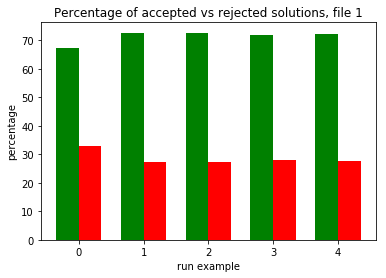

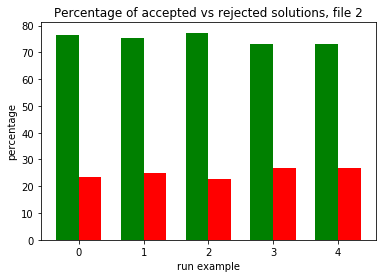

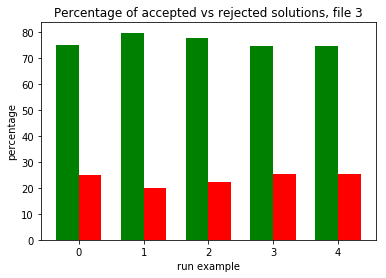

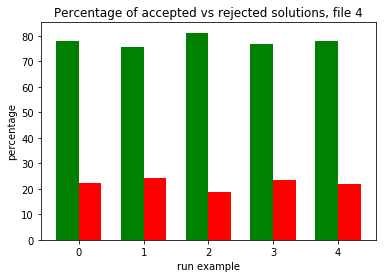

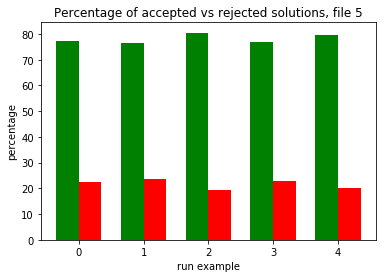

In [41]:
# the should accept ratios
for file in range(5):
    positives = []
    negatives = []

    for example in range(5):
        df = JSSP_dfs[file + 4][example]
        
        num_positives = df[df['should_accept'] == " True"].shape[0]
        num_negatives = df[df['should_accept'] == " False"].shape[0]
        total = num_positives + num_negatives
        positives.append(num_positives * 100 / total)
        negatives.append(num_negatives * 100 / total)
        
    N = 5
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, positives, width, color='green')
    rects2 = ax.bar(ind + width, negatives, width, color='red')

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([str(value) for value in range(N)])
    
    plt.title('Percentage of accepted vs rejected solutions, file {0}'.format(str(file + 1)))
    plt.ylabel('percentage')
    plt.xlabel('run example')
    plt.show()

Con esta información sabemos que el número de veces que que se acepta una solución es mayor a las veces que es rechazada.

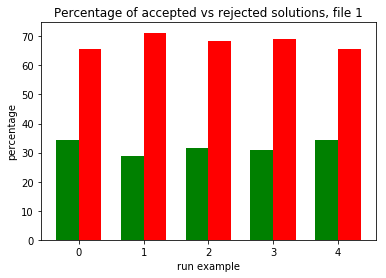

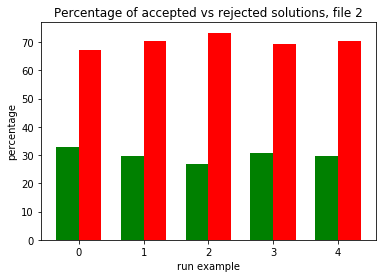

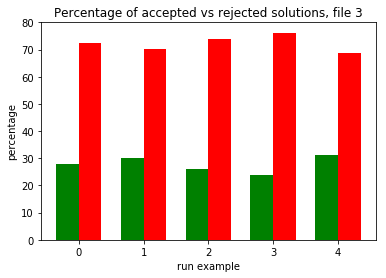

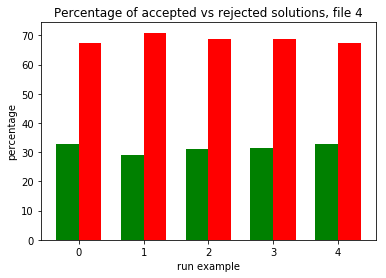

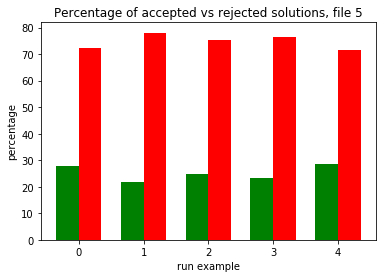

In [42]:
# times a valid solution was accepted and it did not violate a constraint
for file in range(5):
    positives = []
    negatives = []

    for example in range(5):
        df = JSSP_dfs[file + 4][example]
        df = df.loc[:, ["should_accept", "violates_constraint"]]
    
        num_positives = df[df['should_accept'] == " True"]
        num_pos = num_positives[num_positives['violates_constraint'] == " False"]
        num_neg = num_positives[num_positives['violates_constraint'] == " True"]
        num_positives = num_pos.shape[0]
        num_negatives = num_neg.shape[0]

        total = num_positives + num_negatives
        positives.append(num_positives * 100 / total)
        negatives.append(num_negatives * 100 / total)
        
    N = 5
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, positives, width, color='green')
    rects2 = ax.bar(ind + width, negatives, width, color='red')

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([str(value) for value in range(N)])
    
    plt.title('Percentage of accepted vs rejected solutions, file {0}'.format(str(file + 1)))
    plt.ylabel('percentage')
    plt.xlabel('run example')
    plt.show()

Sin embargo, es una historia muy diferente cuando vemos cuales soluciones son las que son acceptadas y no violan alguna restricción. En promedio sólo 30% de las soluciones generads son útiles.

In [44]:
# time graph of temperature and the times a first op was moved with constraint violation

plots = []
for file in range(5):
    p = figure(plot_width=4000, plot_height=300, title="file {0}".format(file + 1))
    
    example = 0
    df = JSSP_dfs[4 + file][example]
    ys = df.loc[:, 'current_temp'].tolist()
    xs = list(range(df.shape[0]))

    p.line(xs, ys, line_width=2)

    def mscatter(p, x, y, typestr):
        p.scatter(x, y, marker=typestr, line_color="#6666ee", fill_color="#ee6666", fill_alpha=0.5, size=12)

    def mscatter2(p, x, y, typestr):
        p.scatter(x, y, marker=typestr, line_color="#6666ee", fill_color="green", fill_alpha=0.5, size=12)

    for ((op, accepted), (x, y)), violates in zip(zip(zip(df.loc[:, 'first_op_moved'].tolist(), 
                                                      df.loc[:, 'should_accept'].tolist()), zip(xs, ys)),
                                                 df.loc[:, 'violates_constraint'].tolist()):
        if op == " True":
            mscatter(p, x, y, "circle")

            if accepted == " True":
                mscatter(p, x, y + 0.5, "triangle")

            if violates == " False":
                mscatter(p, x, y + 1, "square")

        if op == " True" and accepted == " True" and violates == " False":
            mscatter2(p, x, y - 0.5, "circle")
    
    p.xaxis.axis_label = "Iteration"
    p.xaxis.axis_label_text_color = "#aa6666"
    p.yaxis.axis_label = "Temperature"
    p.yaxis.axis_label_text_color = "#aa6666"
    
    plots.append([p])

p = gridplot(plots, toolbar_location="left", title="Current Makespan alongside Best Makespan per Iteration Comparison")
show(p)

Los resultados muestran que no existe relación aparente entre el valor de la temperatura y la influencia de mover la primera operación de la maquina. El número de veces que esta acción tuvo exito fue mínima en comparación a las veces que fracasó.

In [46]:
# time graph of temperature and the times a last op was moved with constraint violation
plots = []
for file in range(5):
    p = figure(plot_width=4000, plot_height=300, title="file {0}".format(file + 1))
    
    example = 0
    df = JSSP_dfs[4 + file][example]
    ys = df.loc[:, 'current_temp'].tolist()
    xs = list(range(df.shape[0]))

    p.line(xs, ys, line_width=2)

    def mscatter(p, x, y, typestr):
        p.scatter(x, y, marker=typestr, line_color="#6666ee", fill_color="#ee6666", fill_alpha=0.5, size=12)
    
    def mscatter2(p, x, y, typestr):
        p.scatter(x, y, marker=typestr, line_color="#6666ee", fill_color="green", fill_alpha=0.5, size=12)

    for ((op, accepted), (x, y)), violates in zip(zip(zip(df.loc[:, 'last_op_moved'].tolist(), 
                                                      df.loc[:, 'should_accept'].tolist()), zip(xs, ys)),
                                                 df.loc[:, 'violates_constraint'].tolist()):
        if op == " True":
            mscatter(p, x, y, "circle")

            if accepted == " True":
                mscatter(p, x, y + 0.5, "triangle")

            if violates == " False":
                mscatter(p, x, y + 1, "square")

        if op == " True" and accepted == " True" and violates == " False":
            mscatter2(p, x, y - 0.5, "circle")
    
    p.xaxis.axis_label = "Iteration"
    p.xaxis.axis_label_text_color = "#aa6666"
    p.yaxis.axis_label = "Temperature"
    p.yaxis.axis_label_text_color = "#aa6666"
    
    plots.append([p])

p = gridplot(plots, toolbar_location="left", title="Current Makespan alongside Best Makespan per Iteration Comparison")
show(p)


La gráfica muestra que la probabilidad de escoger una operación del final es mínima o nula.

In [12]:
# time graph of temperature and constraint violations
df = JSSP_dfs[4][0]
xs = list(range(df.shape[0]))
ys = df.loc[:, 'current_temp'].tolist()
p = figure(plot_width=4000, plot_height=300)
p.line(xs, ys, line_width=2)
    
for (x, y), violates in zip(zip(xs, ys), df.loc[:, 'violates_constraint'].tolist()):         
    if violates == " True":
        mscatter(p, x, y, "circle")
    else:
        mscatter2(p, x, y + 0.5, "circle")
show(p)

In [13]:
# time graph of temperature and constraint violations
df = JSSP_dfs[4][0]
xs = list(range(df.shape[0]))
ys = df.loc[:, 'current_temp'].tolist()
p = figure(plot_width=4000, plot_height=300)
p.line(xs, ys, line_width=2)
    
for (x, y), (accept, violates) in zip(zip(xs, ys), zip(df.loc[:, 'should_accept'].tolist(),
                                                       df.loc[:, 'violates_constraint'].tolist())):         
    if violates == " False" and accept == " True":
        mscatter2(p, x, y, "circle")
    else:
        mscatter(p, x, y + 0.5, "circle")
show(p)

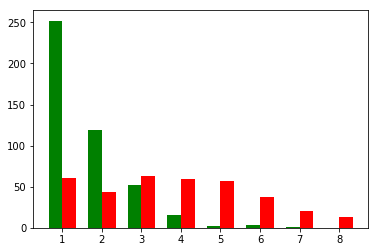

In [14]:

# for file 4 (index 3) example 1
positives = []
negatives = []
df = JSSP_dfs[3][0]
df = df.loc[:, ["violates_constraint", "moves"]]

num_positives = df[df['violates_constraint'] == " False"]
num_negatives = df[df['violates_constraint'] == " True"]

number_of_moves = set(df.loc[:, "moves"].tolist())

for move_count in sorted(number_of_moves):
    positives.append(num_positives[num_positives["moves"] == move_count].shape[0])
    negatives.append(num_negatives[num_negatives["moves"] == move_count].shape[0])
    
N = len(number_of_moves)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(N), positives, width, color='green')
rects2 = ax.bar(np.arange(N) + width, negatives, width, color='red')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels([str(value) for value in sorted(number_of_moves)])

plt.show()

La gráfica de arriba muestra es número de veces que no se violó ninguna restricción vs. las veces que si dependiendo del número de desplazamientos realizados.

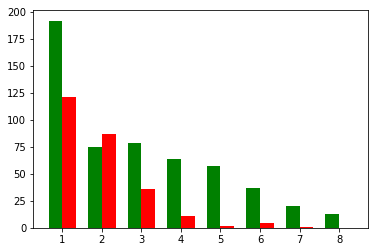

In [15]:

# for file 4 (index 3) example 1
positives = []
negatives = []
df = JSSP_dfs[3][0]
df = df.loc[:, ["should_accept", "moves"]]

num_positives = df[df['should_accept'] == " True"]
num_negatives = df[df['should_accept'] == " False"]

number_of_moves = set(df.loc[:, "moves"].tolist())

for move_count in sorted(number_of_moves):
    positives.append(num_positives[num_positives["moves"] == move_count].shape[0])
    negatives.append(num_negatives[num_negatives["moves"] == move_count].shape[0])
    
N = len(number_of_moves)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(N), positives, width, color='green')
rects2 = ax.bar(np.arange(N) + width, negatives, width, color='red')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels([str(value) for value in sorted(number_of_moves)])

plt.show()

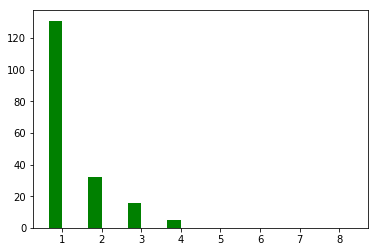

In [16]:
# for file 4 (index 3) example 1
positives = []
negatives = []
df = JSSP_dfs[3][0]
df = df.loc[:, ["violates_constraint", "should_accept",  "moves"]]

num_positives = df[df['violates_constraint'] == " False"]
num_positives = num_positives[num_positives['should_accept'] == " True"]
num_negatives = df[df['violates_constraint'] == " True"]
num_negatives = num_negatives[num_negatives['should_accept'] == " False"]

number_of_moves = set(df.loc[:, "moves"].tolist())

for move_count in sorted(number_of_moves):
    positives.append(num_positives[num_positives["moves"] == move_count].shape[0])
    negatives.append(num_negatives[num_negatives["moves"] == move_count].shape[0])
    
N = len(number_of_moves)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(N), positives, width, color='green')
rects2 = ax.bar(np.arange(N) + width, negatives, width, color='red')

ax.set_xticks(ind + width / 2)
ax.set_xticklabels([str(value) for value in sorted(number_of_moves)])

plt.show()

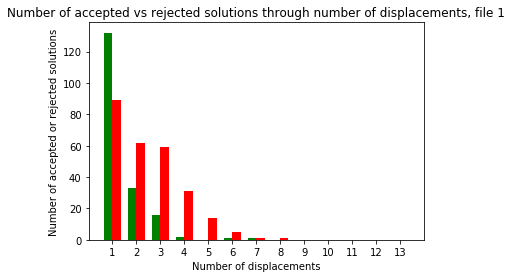

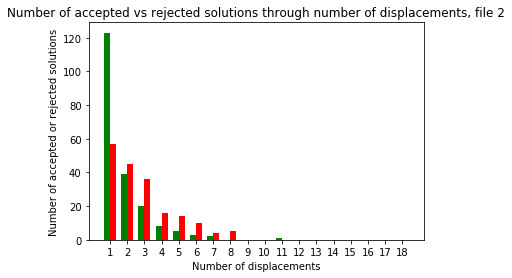

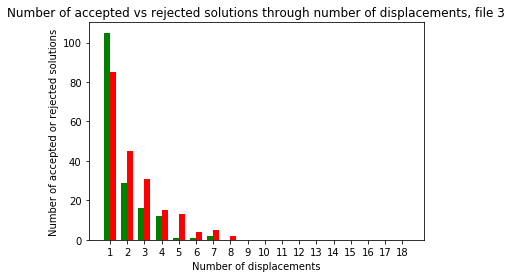

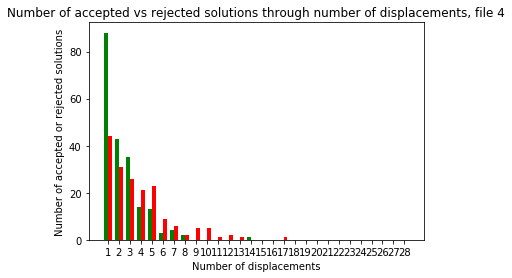

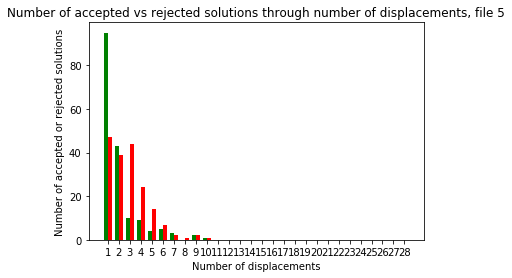

In [51]:
# for file 4 (index 3) example 1
for file in range(5):
    positives = []
    negatives = []

    example = 0
    df = JSSP_dfs[file + 4][example]
    df = df.loc[:, ["violates_constraint", "should_accept",  "moves"]]

    num_positives = df[df['violates_constraint'] == " False"]
    num_positives = num_positives[num_positives['should_accept'] == " True"]
    num_negatives = df[df['violates_constraint'] == " False"]
    num_negatives = num_negatives[num_negatives['should_accept'] == " False"]

    number_of_moves = set(df.loc[:, "moves"].tolist())

    for move_count in sorted(number_of_moves):
        positives.append(num_positives[num_positives["moves"] == move_count].shape[0])
        negatives.append(num_negatives[num_negatives["moves"] == move_count].shape[0])
        
    N = len(number_of_moves)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(np.arange(N), positives, width, color='green')
    rects2 = ax.bar(np.arange(N) + width, negatives, width, color='red')

    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels([str(value) for value in sorted(number_of_moves)])
    
    plt.title('Number of accepted vs rejected solutions through number of displacements, file {0}'.format(str(file + 1)))
    plt.ylabel('Number of accepted or rejected solutions')
    plt.xlabel('Number of displacements')
    plt.show()

Esta es la gráfica más importante ya que demuestra que moverse más de 4 veces es poco útil debido a la alta probabilidad de generar una solución que será al final rechazada.

In [58]:
# time graph of temperature and constraint violations
plots = []
for file in range(5):
    df = JSSP_dfs[file + 4][0]
    p = figure(plot_width=400, plot_height=400, title="file {0}".format(str(file + 1)))

    xs = sorted(set(df.loc[:, "moves"].tolist()))
    ys = [20, 40]
    left_moves = []
    right_moves = []
    
    for x in xs:
        moves = df[df["moves"] == x]
        right_move = moves[moves["move_direction"] == " right"]
        left_move = moves[moves["move_direction"] == " left"]

        right_move = right_move[right_move["should_accept"] == " True"]
        right_move = right_move[right_move["violates_constraint"] == " False"].shape[0]

        left_move = left_move[left_move["should_accept"] == " True"]
        left_move = left_move[left_move["violates_constraint"] == " False"].shape[0]

        left_moves.append(left_move)
        right_moves.append(right_move)

    def mscatter(p, x, y, fill_color, size):
        p.scatter(x, y, marker="circle", line_color="#6666ee", fill_color=fill_color, fill_alpha=0.5, size=size)

    for x, (left, right) in zip(xs, zip(left_moves, right_moves)):
        mscatter(p, x, ys[0], "blue", left * 3)
        mscatter(p, x, ys[1], "purple", right * 3)
        
    p.xaxis.axis_label = "Number of Displacements"
    p.xaxis.axis_label_text_color = "#aa6666"
    p.yaxis.axis_label = "left      -      right"
    p.yaxis.axis_label_text_color = "#aa6666"
    
    plots.append([p])

p = gridplot(plots, toolbar_location="left")
show(p)